In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, log_loss
import scipy
import random
import pickle
import joblib

In [620]:
#Import model and data

xreb = pickle.load(open("log_xrebounds.pkl", 'rb'))
xg_model=pickle.load(open("/Users/kyledelaney/xgboost_xg.pkl", 'rb'))
shots_sorted=pd.read_csv(r'/Users/kyledelaney/Downloads/shots_2022 16.csv')

In [ ]:
shots_sorted.drop(columns=['xFroze', 'xGoal', 'xPlayContinuedInZone', 'xPlayContinuedOutsideZone', 'xPlayStopped', 'xRebound', 'xShotWasOnGoal'], inplace=True)

In [59]:
shots_sorted.to_csv(r'/Users/kyledelaney/Downloads/shots_2022.csv', index=False)

In [511]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)

In [6]:
def conditions(shots_sorted):
    if (shots_sorted['team'] == 'HOME'):
        return shots_sorted['awayTeamCode']
    else:
        return shots_sorted['homeTeamCode']

In [7]:
def new_conditions(shots_sorted):
    if (shots_sorted['homeTeamWon'] == 1):
        return shots_sorted['homeTeamCode']
    else:
        return shots_sorted['awayTeamCode']

In [8]:
def goalie_win(shots_sorted):
    if (shots_sorted['goalieTeam'] == shots_sorted['teamWin']):
        return 1
    else:
        return 0

In [622]:
# Create function to clean dataset

def clean_data(shots_sorted):

    """
    1. clean the shots data
    2. add new necessary columns
    """
    ###add shot types
    shots_sorted['type_backhand']=np.where(shots_sorted['shotType'] == 'BACK', 1,0)
    shots_sorted['type_wrist']=np.where(shots_sorted['shotType'] == 'WRIST',1,0)
    shots_sorted['type_slap']=np.where(shots_sorted['shotType'] == 'SLAP',1,0)
    shots_sorted['type_tipin']=np.where(shots_sorted['shotType'] == 'TIP',1,0)
    shots_sorted['type_deflect']=np.where(shots_sorted['shotType'] == 'DEFL',1,0)
    shots_sorted['type_wrap']=np.where(shots_sorted['shotType'] == 'WRAP',1,0)
    shots_sorted['type_snap']=np.where(shots_sorted['shotType'] == 'SNAP',1,0)
    shots_sorted['shotType'].fillna("NA", inplace=True)
    
    #add strengths
    shots_sorted['strength_3x3']=np.where((shots_sorted['homeSkatersOnIce'] == 3) & (shots_sorted['awaySkatersOnIce'] == 3),1,0)
    shots_sorted['strength_3x4']=np.where((shots_sorted['homeSkatersOnIce'] == 3) & (shots_sorted['awaySkatersOnIce'] == 4),1,0)
    shots_sorted['strength_3x5']=np.where((shots_sorted['homeSkatersOnIce'] == 3) & (shots_sorted['awaySkatersOnIce'] == 5),1,0)
    shots_sorted['strength_3x6']=np.where((shots_sorted['homeSkatersOnIce'] == 3) & (shots_sorted['awaySkatersOnIce'] == 6),1,0)
    shots_sorted['strength_4x3']=np.where((shots_sorted['homeSkatersOnIce'] == 4) & (shots_sorted['awaySkatersOnIce'] == 3),1,0)
    shots_sorted['strength_4x4']=np.where((shots_sorted['homeSkatersOnIce'] == 4) & (shots_sorted['awaySkatersOnIce'] == 4),1,0)
    shots_sorted['strength_4x5']=np.where((shots_sorted['homeSkatersOnIce'] == 4) & (shots_sorted['awaySkatersOnIce'] == 5),1,0)
    shots_sorted['strength_4x6']=np.where((shots_sorted['homeSkatersOnIce'] == 4) & (shots_sorted['awaySkatersOnIce'] == 6),1,0)
    shots_sorted['strength_5x3']=np.where((shots_sorted['homeSkatersOnIce'] == 5) & (shots_sorted['awaySkatersOnIce'] == 3),1,0)
    shots_sorted['strength_5x4']=np.where((shots_sorted['homeSkatersOnIce'] == 5) & (shots_sorted['awaySkatersOnIce'] == 4),1,0)
    shots_sorted['strength_5x5']=np.where((shots_sorted['homeSkatersOnIce'] == 5) & (shots_sorted['awaySkatersOnIce'] == 5),1,0)
    shots_sorted['strength_5x6']=np.where((shots_sorted['homeSkatersOnIce'] == 5) & (shots_sorted['awaySkatersOnIce'] == 6),1,0)
    shots_sorted['strength_6x3']=np.where((shots_sorted['homeSkatersOnIce'] == 6) & (shots_sorted['awaySkatersOnIce'] == 3),1,0)
    shots_sorted['strength_6x4']=np.where((shots_sorted['homeSkatersOnIce'] == 6) & (shots_sorted['awaySkatersOnIce'] == 4),1,0)
    shots_sorted['strength_6x5']=np.where((shots_sorted['homeSkatersOnIce'] == 6) & (shots_sorted['awaySkatersOnIce'] == 5),1,0)

    ### add column for forward
    shots_sorted['isforward'] = np.where(shots_sorted['playerPositionThatDidEvent'].isin(["LW", "RW", "C"]), 1, 0)

    ### remove playoffs & shootouts
    shots_sorted=shots_sorted[shots_sorted.isPlayoffGame != 1]

    ### remove goalie shots
    shots_sorted['goalieNameForShot'].fillna("Empty", inplace=True)
   

    ### add outcomes
    shots_sorted['Outcome'] = np.where(shots_sorted['event'] == "GOAL", 2, np.where(shots_sorted['event'] == "SHOT", 1, np.where(shots_sorted['event'] == "MISS", 0, 3)))
    shots_sorted = shots_sorted[shots_sorted['Outcome'] != 3]

    # Change giveaway to takeaway for other team
    shots_sorted['lastEventTeam'] = np.where(shots_sorted['lastEventCategory'] != "GIVE", shots_sorted["lastEventTeam"],np.where(shots_sorted['lastEventTeam'] == 'HOME', 'AWAY', 'HOME'))
    shots_sorted['lastEventCategory'] = np.where(shots_sorted['lastEventCategory'] == "GIVE", "TAKE", shots_sorted['lastEventCategory'])

    ### add column for same team events
    shots_sorted['if_prev_ev_team'] = np.where(shots_sorted['team'] == shots_sorted['lastEventTeam'], 1, 0)

    # Get if last event was by event team for specified events
    shots_sorted['prev_evTeam_Fac'] = np.where((shots_sorted['if_prev_ev_team'] == 1) & (shots_sorted['lastEventCategory'] == "FAC"), 1, 0)
    shots_sorted['prev_evTeam_NonSog'] = np.where((shots_sorted['if_prev_ev_team'] == 1) & (shots_sorted['lastEventCategory'].isin(["MISS", "BLOCK"])), 1, 0)
    shots_sorted['prev_evTeam_NonShot'] = np.where((shots_sorted['if_prev_ev_team'] == 1) & (shots_sorted['lastEventCategory'].isin(["TAKE", "HIT"])), 1, 0)
    shots_sorted['prev_evTeam_Sog'] = np.where((shots_sorted['if_prev_ev_team'] == 1) & (shots_sorted['lastEventCategory'] == "SHOT"), 1, 0)

    # Get if last event was by non-event team for specified events
    shots_sorted['prev_non_evTeam_Fac'] = np.where((shots_sorted['if_prev_ev_team'] == 0) & (shots_sorted['lastEventCategory'] == "FAC"), 1, 0)
    shots_sorted['prev_non_evTeam_NonSog'] = np.where((shots_sorted['if_prev_ev_team'] == 0) & (shots_sorted['lastEventCategory'].isin(["MISS", "BLOCK"])),1, 0)
    shots_sorted['prev_non_evTeam_NonShot'] = np.where((shots_sorted['if_prev_ev_team'] == 0) & (shots_sorted['lastEventCategory'].isin(["TAKE", "HIT"])), 1,0)
    shots_sorted['prev_non_evTeam_Sog'] = np.where((shots_sorted['if_prev_ev_team'] == 0) & (shots_sorted['lastEventCategory'] == "SHOT"), 1, 0)

    ### add column for non-SOG rebounds
    shots_sorted['non_sog_rebound'] = np.where((shots_sorted['lastEventCategory'].isin(["MISS", "BLOCK"])) & (shots_sorted['timeUntilNextEvent'] <= 2.0)& (shots_sorted['team'] == shots_sorted['lastEventTeam']), 1, 0)
    
    
    ### add goalie categories
    shots_sorted['goalieTeam'] = shots_sorted.apply(conditions, axis=1)
    shots_sorted['teamWin'] = shots_sorted.apply(new_conditions, axis=1)
    shots_sorted['goalieWin'] = shots_sorted.apply(goalie_win, axis=1)

    ### add score categories
    ### stop at +3 and -3
    shots_sorted['score_cat'] = np.where(shots_sorted['homeTeamGoals'] - shots_sorted['awayTeamGoals'] >= 3, 3, np.where(shots_sorted['homeTeamGoals'] - shots_sorted['awayTeamGoals'] <= -3, -3, shots_sorted['homeTeamGoals'] - shots_sorted['awayTeamGoals']))
    shots_sorted['score_cat'] = np.where(shots_sorted['teamCode'] == shots_sorted['isHomeTeam'], shots_sorted['score_cat'], -shots_sorted['score_cat'])
    shots_sorted['score_cat_3'] = np.where((shots_sorted['score_cat'] >= 3), 1, 0)
    shots_sorted['score_cat_2'] = np.where((shots_sorted['score_cat'] == 2), 1, 0)
    shots_sorted['score_cat_1'] = np.where((shots_sorted['score_cat'] == 1), 1, 0)
    shots_sorted['score_cat_0'] = np.where((shots_sorted['score_cat'] == 0), 1, 0)
    shots_sorted['score_cat_-1'] = np.where((shots_sorted['score_cat'] == -1), 1, 0)
    shots_sorted['score_cat_-2'] = np.where((shots_sorted['score_cat'] == -2), 1, 0)
    shots_sorted['score_cat_-3'] = np.where((shots_sorted['score_cat'] <= -3), 1, 0)


    ### drop dupes
    shots_sorted = shots_sorted[shots_sorted["arenaAdjustedXCord"].notnull()]
    shots_sorted = shots_sorted[shots_sorted["arenaAdjustedYCord"].notnull()]
    shots_sorted = shots_sorted[shots_sorted["lastEventxCord_adjusted"].notnull()]
    shots_sorted = shots_sorted[shots_sorted["lastEventyCord_adjusted"].notnull()]
    

    return shots_sorted

shots_sorted=clean_data(shots_sorted)
display(shots_sorted)

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,yCord,yCordAdjusted,type_backhand,type_wrist,type_slap,type_tipin,type_deflect,type_wrap,type_snap,strength_3x3,strength_3x4,strength_3x5,strength_3x6,strength_4x3,strength_4x4,strength_4x5,strength_4x6,strength_5x3,strength_5x4,strength_5x5,strength_5x6,strength_6x3,strength_6x4,strength_6x5,isforward,Outcome,if_prev_ev_team,prev_evTeam_Fac,prev_evTeam_NonSog,prev_evTeam_NonShot,prev_evTeam_Sog,prev_non_evTeam_Fac,prev_non_evTeam_NonSog,prev_non_evTeam_NonShot,prev_non_evTeam_Sog,non_sog_rebound,goalieTeam,teamWin,goalieWin,score_cat,score_cat_3,score_cat_2,score_cat_1,score_cat_0,score_cat_-1,score_cat_-2,score_cat_-3
0,0,43.000000,47.0,47.0,8.0,8.0,0.000000,0,0,0,5,SJS,0,23.000000,23.0,23.0,23.000000,23.000000,23.000000,2,3,23,23,23,23,23,23,23,23,23,23,23,23,127.345985,SHOT,20001,0,8477424,Juuse Saros,0,0,0,5,NSH,0,1,8,0.0,0,HIT,0.000000,0.000000,AWAY,-80,-80,37,37,HOMEZONE,0,1,28,0,R,2022,L,Timo Meier,8478414.0,23,23,23.0,23.0,23.0,23.000000,23.000000,23.0,2,3,23,23,23,23,23,23,23,23,23,23,23,23,10.080598,10.080598,0.000000,0.000000,0,45.705580,0,1,0,0,0,0,0,0,WRIST,1.0,21.224331,AWAY,SJS,23,0,23,6,1,44,44,8,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,NSH,NSH,1,0,0,0,0,1,0,0,0
1,1,

In [623]:
# Convert data to model format

data = shots_sorted
    
data['Outcome'] = np.where(shots_sorted['Outcome'] == 0, 0, np.where(shots_sorted['Outcome'] == 1, 0, np.where(shots_sorted['Outcome'] == 2, 1, 3)))
data = shots_sorted[shots_sorted['Outcome'] != 3]

####Convert the data to use in model
all_variables = ['arenaAdjustedShotDistance', 'arenaAdjustedXCord','lastEventxCord_adjusted','arenaAdjustedYCord','lastEventyCord_adjusted','shotAngleAdjusted','awayEmptyNet', 'homeEmptyNet', 'speedFromLastEvent', 'shotAnglePlusReboundSpeed','distanceFromLastEvent', 'timeSinceLastEvent','type_backhand', 'type_deflect', 'type_slap','type_snap', 'type_tipin', 'type_wrap', 'type_wrist','strength_3x3','strength_3x4', 'strength_3x5', 'strength_3x6', 'strength_4x3','strength_4x4', 'strength_4x5', 'strength_4x6', 'strength_5x3','strength_5x4', 'strength_5x5', 'strength_5x6', 'strength_6x3', 'strength_6x4', 'strength_6x5','score_cat_-3', 'score_cat_-2', 'score_cat_-1', 'score_cat_0', 'score_cat_1', 'score_cat_2', 'score_cat_3','isforward','isHomeTeam','prev_evTeam_Fac', 'prev_evTeam_NonSog', 'prev_evTeam_NonShot', 'prev_evTeam_Sog','prev_non_evTeam_Fac', 'prev_non_evTeam_NonSog', 'prev_non_evTeam_NonShot', 'prev_non_evTeam_Sog']

categorical_variables = ['shotType', 'score_cat', 'lastEventCategory']
labels = ['Outcome']

df_dummies = pd.get_dummies(data, columns=categorical_variables)
model_df = df_dummies[all_variables + ["Outcome"]]

model_features = model_df[all_variables].values.tolist()
model_labels = model_df[labels].values.tolist()

# Convert to lists
features=model_features
labels=model_labels

# Split into training and testing sets -> 80/20
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=.2, random_state=42)

# Fix Data
features_train, labels_train = np.array(features_train), np.array(labels_train).ravel()

In [624]:
# Use model to calculate goal probability of all shots

xgboost_predict=xg_model.predict_proba(features)

In [625]:
# Create dataframe of probabilities

xgb=data[['Outcome', 'shotID']]
xgpredict=pd.DataFrame(xgboost_predict, columns=['0','1'])
xgb=xgb.join(xgpredict, how='right')
xgb.dropna(inplace=True)
display(xgb)

,Outcome,shotID,0,1
0,0,0,0.971954,0.028046
1,0,1,0.990366,0.009634
2,0,2,0.947475,0.052525
3,1,3,0.668581,0.331419
4,0,4,0.944049,0.055951
...,...,...,...,...
53371,0,857,0.899851,0.100149
53372,0,858,0.984716,0.015284
53373,1,859,0.197445,0.802555
53374,0,860,0.989555,0.010445


In [626]:
# Merge xGoal probabilities into main dataset

xgb=xgb.rename(columns={"0":"xNotGoal","1":"xGoal"})
xgb=xgb.drop(columns=["Outcome", "shotID", "xNotGoal"])
xgboost_xg=xgb.join(shots_sorted, how='left')
xgboost_xg['GSAx'] = xgboost_xg['xGoal'] - xgboost_xg['goal']
xgboost_xg['shot_attempt'] = 1
display(xgboost_xg)

,xGoal,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,yCord,yCordAdjusted,type_backhand,type_wrist,type_slap,type_tipin,type_deflect,type_wrap,type_snap,strength_3x3,strength_3x4,strength_3x5,strength_3x6,strength_4x3,strength_4x4,strength_4x5,strength_4x6,strength_5x3,strength_5x4,strength_5x5,strength_5x6,strength_6x3,strength_6x4,strength_6x5,isforward,Outcome,if_prev_ev_team,prev_evTeam_Fac,prev_evTeam_NonSog,prev_evTeam_NonShot,prev_evTeam_Sog,prev_non_evTeam_Fac,prev_non_evTeam_NonSog,prev_non_evTeam_NonShot,prev_non_evTeam_Sog,non_sog_rebound,goalieTeam,teamWin,goalieWin,score_cat,score_cat_3,score_cat_2,score_cat_1,score_cat_0,score_cat_-1,score_cat_-2,score_cat_-3,GSAx,shot_attempt
0,0.028046,0,43.000000,47.0,47.0,8.0,8.0,0.000000,0,0,0,5,SJS,0,23.000000,23.0,23.0,23.000000,23.000000,23.000000,2,3,23,23,23,23,23,23,23,23,23,23,23,23,127.345985,SHOT,20001,0,8477424,Juuse Saros,0,0,0,5,NSH,0,1,8,0.0,0,HIT,0.000000,0.000000,AWAY,-80,-80,37,37,HOMEZONE,0,1,28,0,R,2022,L,Timo Meier,8478414.0,23,23,23.0,23.0,23.0,23.000000,23.000000,23.0,2,3,23,23,23,23,23,23,23,23,23,23,23,23,10.080598,10.080598,0.000000,0.000000,0,45.705580,0,1,0,0,0,0,0,0,WRIST,1.0,21.224331,AWAY,SJS,23,0,23,6,1,44,44,8,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0

In [627]:
data = shots_sorted
    
data['shotGeneratedRebound'] = np.where(data['shotGeneratedRebound'] == 0, 0, np.where(data['shotGeneratedRebound'] == 1, 1, 2))
data = data[data['shotGeneratedRebound'] != 2]

####Convert the data to use in model
all_variables = ['arenaAdjustedShotDistance', 'arenaAdjustedXCord','lastEventxCord_adjusted','arenaAdjustedYCord','lastEventyCord_adjusted','shotAngleAdjusted','awayEmptyNet', 'homeEmptyNet', 'speedFromLastEvent', 'shotAnglePlusReboundSpeed','distanceFromLastEvent', 'timeSinceLastEvent','type_backhand', 'type_deflect', 'type_slap','type_snap', 'type_tipin', 'type_wrap', 'type_wrist','strength_3x3','strength_3x4', 'strength_3x5', 'strength_3x6', 'strength_4x3','strength_4x4', 'strength_4x5', 'strength_4x6', 'strength_5x3','strength_5x4', 'strength_5x5', 'strength_5x6', 'strength_6x3', 'strength_6x4', 'strength_6x5','score_cat_-3', 'score_cat_-2', 'score_cat_-1', 'score_cat_0', 'score_cat_1', 'score_cat_2', 'score_cat_3','isforward','isHomeTeam','prev_evTeam_Fac', 'prev_evTeam_NonSog', 'prev_evTeam_NonShot', 'prev_evTeam_Sog','prev_non_evTeam_Fac', 'prev_non_evTeam_NonSog', 'prev_non_evTeam_NonShot', 'prev_non_evTeam_Sog']

categorical_variables = ['shotType', 'score_cat', 'lastEventCategory']
labels = ['shotGeneratedRebound']

df_dummies = pd.get_dummies(data, columns=categorical_variables)
model_df = df_dummies[all_variables + ["shotGeneratedRebound"]]

model_features = model_df[all_variables].values.tolist()
model_labels = model_df[labels].values.tolist()

# Convert to lists
features=model_features
labels=model_labels

# Split into training and testing sets -> 80/20
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=.2, random_state=42)

# Fix Data
features_train, labels_train = np.array(features_train), np.array(labels_train).ravel()

In [628]:
xreb_predict = xreb.predict_proba(features)

In [629]:
# Create dataframe of probabilities

xrebs=data[['shotGeneratedRebound', 'shotID']]
xrebounds=pd.DataFrame(xreb_predict, columns=['0','1'])
xrebs=xrebs.join(xrebounds, how='right')
xrebs.dropna(inplace=True)
xrebs=xrebs.rename(columns={"0":"xNotRebound","1":"xRebound"})
xrebs=xrebs.drop(columns=["shotGeneratedRebound", "xNotRebound", "shotID"])
xgboost_xg=xrebs.join(xgboost_xg, how='left')
xgboost_xg['RSAx'] = xgboost_xg['xRebound'] - xgboost_xg['shotGeneratedRebound']
display(xgboost_xg)

,xRebound,xGoal,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,yCord,yCordAdjusted,type_backhand,type_wrist,type_slap,type_tipin,type_deflect,type_wrap,type_snap,strength_3x3,strength_3x4,strength_3x5,strength_3x6,strength_4x3,strength_4x4,strength_4x5,strength_4x6,strength_5x3,strength_5x4,strength_5x5,strength_5x6,strength_6x3,strength_6x4,strength_6x5,isforward,Outcome,if_prev_ev_team,prev_evTeam_Fac,prev_evTeam_NonSog,prev_evTeam_NonShot,prev_evTeam_Sog,prev_non_evTeam_Fac,prev_non_evTeam_NonSog,prev_non_evTeam_NonShot,prev_non_evTeam_Sog,non_sog_rebound,goalieTeam,teamWin,goalieWin,score_cat,score_cat_3,score_cat_2,score_cat_1,score_cat_0,score_cat_-1,score_cat_-2,score_cat_-3,GSAx,shot_attempt,RSAx
0,0.040176,0.028046,0,43.000000,47.0,47.0,8.0,8.0,0.000000,0,0,0,5,SJS,0,23.000000,23.0,23.0,23.000000,23.000000,23.000000,2,3,23,23,23,23,23,23,23,23,23,23,23,23,127.345985,SHOT,20001,0,8477424,Juuse Saros,0,0,0,5,NSH,0,1,8,0.0,0,HIT,0.000000,0.000000,AWAY,-80,-80,37,37,HOMEZONE,0,1,28,0,R,2022,L,Timo Meier,8478414.0,23,23,23.0,23.0,23.0,23.000000,23.000000,23.0,2,3,23,23,23,23,23,23,23,23,23,23,23,23,10.080598,10.080598,0.000000,0.000000,0,45.705580,0,1,0,0,0,0,0,0,WRIST,1.0,21.224331,AWAY,SJS,23,0,23,6,1,44,44,8,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [630]:
xgboost_xg.to_csv(r'/Users/kyledelaney/Downloads/xg_22.csv', index=False)

In [631]:
# Create a GameScore for goalies

game_score_xgb = xgboost_xg[['goalieNameForShot', 'goalieTeam', 'teamCode','xGoal', 'goal', 'GSAx', "xRebound", 'RSAx', 'season', 'game_id', 'shotWasOnGoal','shotGoalieFroze','shotRebound','shotRush']]
game_score_xgb=game_score_xgb[game_score_xgb.goalieNameForShot != 'Empty']
game_score_xgb=game_score_xgb.groupby(['goalieNameForShot', 'goalieTeam', 'teamCode','game_id','season']).sum()
game_score_xgb['shotSaved']=game_score_xgb['shotWasOnGoal'] - game_score_xgb['goal']
game_score_xgb['savePCT']=game_score_xgb['shotSaved']/game_score_xgb['shotWasOnGoal']
game_score_xgb['xSvPCT'] = (game_score_xgb['shotWasOnGoal']-game_score_xgb['xGoal']) / game_score_xgb['shotWasOnGoal']
game_score_xgb['SPAx'] = game_score_xgb['savePCT'] - game_score_xgb['xSvPCT']
game_score_xgb['gameScore']=(-0.75*game_score_xgb['goal']) + (0.1*game_score_xgb['shotSaved']) + (0.3*game_score_xgb['GSAx'] + (0.05*game_score_xgb['RSAx']))
game_score_xgb['GP']=1
game_score_xgb=game_score_xgb.reset_index()
game_score_xgb=game_score_xgb.astype({'season':'int64','game_id':'int64', 'goal':'int64','shotSaved':'int64','shotWasOnGoal':'int64'})
display(game_score_xgb.style.format({'savePCT': "{:.2%}".format,'xSvPCT': "{:.2%}".format, 'SPAx':"{:.2%}".format}))

,goalieNameForShot,goalieTeam,teamCode,game_id,season,xGoal,goal,GSAx,xRebound,RSAx,shotWasOnGoal,shotGoalieFroze,shotRebound,shotRush,shotSaved,savePCT,xSvPCT,SPAx,gameScore,GP
0,Aaron Dell,SJS,BUF,20395,2022,5.157578,5,0.157578,2.620969,-1.379031,37,8,4,1,32,86.49%,86.06%,0.43%,-0.571678,1
1,Aaron Dell,SJS,TOR,20363,2022,4.221714,2,2.221714,2.045904,-2.954096,31,6,5,0,29,93.55%,86.38%,7.17%,1.918809,1
2,Adin Hill,VGK,ANA,20562,2022,0.521343,2,-1.478657,0.298546,-0.701454,5,0,1,0,3,60.00%,89.57%,-29.57%,-1.678670,1
3,Adin Hill,VGK,BUF,20507,2022,1.218965,3,-1.781035,1.339940,1.339940,18,7,0,0,15,83.33%,93.23%,-9.89%,-1.217314,1
4,Adin Hill,VGK,DET,20386,2022,3.874072,1,2.874072,2.275470,-1.724530,25,2,4,0,24,96.00%,84.50%,11.50%,2.425995,1
5,Adin Hill,VGK,EDM,20287,2022,3.256045,4,-0.743955,1.860462,1.860462,23,2,0,0,19,82.61%,85.84%,-3.23%,-1.230163,1
6,Adin Hill,VGK,MTL,20184,2022,2.358832,4,-1.641168,1.925372,-0.074628,31,3,2,1,27,87.10%,92.39%,-5.29%,-0.796082,1
7,Adin Hill,VGK,PHI,20432,2022,2.247386,1,1.247386,2.137235,-0.862765,28,3,3,0,27,96.43%,91.97%,4.45%,2.281078,1
8,Adin Hill,VGK,PIT,20620,2022,4.436936,2,2.436936,2.601022,-2.398978,40,9,5,0,38,95.00%,88.91%,6.09%,2.911132,1
9,Adin Hill,VGK,SEA,20037,2022,2.639844,2,0.639844,2.143039,1.143039,33,16,1,0,31,93.94%,92.00%,1.94%,1.849105,1


In [641]:
individual = game_score_xgb[game_score_xgb.goalieNameForShot == "Juuse Saros"]
display(individual.sort_values(by=['game_id'], ascending=True).style.format({'savePCT': "{:.2%}",'xSvPCT': "{:.2%}", 'SPAx':"{:.2%}"}))

,goalieNameForShot,goalieTeam,teamCode,game_id,season,xGoal,goal,GSAx,xRebound,RSAx,shotWasOnGoal,shotGoalieFroze,shotRebound,shotRush,shotSaved,savePCT,xSvPCT,SPAx,gameScore,GP
790,Juuse Saros,NSH,SJS,20001,2022,3.487654,1,2.487654,2.469320,-1.530680,31,6,4,0,30,96.77%,88.75%,8.02%,2.919762,1
776,Juuse Saros,NSH,DAL,20016,2022,3.790510,4,-0.209490,2.415114,1.415114,29,5,1,0,25,86.21%,86.93%,-0.72%,-0.492091,1
777,Juuse Saros,NSH,DAL,20035,2022,3.444041,4,-0.555958,1.668092,-0.331908,21,4,2,0,17,80.95%,83.60%,-2.65%,-1.483383,1
781,Juuse Saros,NSH,LAK,20052,2022,6.220993,3,3.220993,2.632425,-1.367575,35,8,4,0,32,91.43%,82.23%,9.20%,1.847919,1
788,Juuse Saros,NSH,PHI,20083,2022,2.115052,3,-0.884948,1.638767,-0.361233,25,7,2,0,22,88.00%,91.54%,-3.54%,-0.333546,1
791,Juuse Saros,NSH,STL,20115,2022,3.890521,2,1.890521,2.459183,1.459183,35,3,1,0,33,94.29%,88.88%,5.40%,2.440115,1
797,Juuse Saros,NSH,WSH,20136,2022,5.285094,2,3.285094,2.818100,-2.181900,34,9,5,0,32,94.12%,84.46%,9.66%,2.576433,1
779,Juuse Saros,NSH,EDM,20154,2022,4.272046,6,-1.727955,2.541657,1.541657,36,14,1,0,30,83.33%,88.13%,-4.80%,-1.941304,1
795,Juuse Saros,NSH,VAN,20186,2022,4.736004,3,1.736004,2.856270,-2.143730,45,7,5,0,42,93.33%,89.48%,3.86%,2.363615,1
789,Juuse Saros,NSH,SEA,20205,2022,0.592567,4,-3.407433,0.378733,0.378733,6,0,0,0,2,33.33%,90.12%,-56.79%,-3.803293,1


In [615]:
# Save GameScore dataset

game_score_xgb.to_csv(r'/Users/kyledelaney/Downloads/goalie_gamescorexgboost2022.csv', index=False)

<AxesSubplot:xlabel='game_id', ylabel='GSAx'>

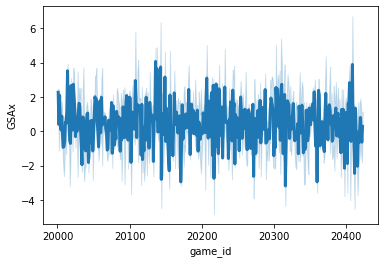

In [378]:
sns.lineplot(
    data=game_score_xgb, x="game_id", y="GSAx", lw=3, markers=True,
    sizes=(20, 250)
)

In [634]:
# Create dataset grouped by game & shot ID's

goalie_shot = xgboost_xg[['goalieNameForShot','shooterName', 'xGoal', 'goal', 'GSAx', 'game_id','shotID','shotType','shotWasOnGoal']]
goalie_shot=goalie_shot.groupby(['goalieNameForShot','shooterName','game_id','shotID','shotType']).sum()
goalie_shot=goalie_shot.reset_index()
goalie_shot=goalie_shot[goalie_shot.goalieNameForShot != "Empty"]
goalie_shot=goalie_shot.astype({'shotID':'int64','game_id':'int64', 'goal':'int64'})
display(goalie_shot.groupby(['game_id','shotID','goalieNameForShot', 'shooterName','shotType']).sum().sort_values(by=['xGoal'], ascending=False))

,,,,,xGoal,goal,GSAx,shotWasOnGoal
game_id,shotID,goalieNameForShot,shooterName,shotType,,,,
20454,39172,Lukas Dostal,Michael Bunting,BACK,0.979736,1,-0.020264,1.0
20582,50095,Andrei Vasilevskiy,Travis Boyd,WRIST,0.970165,0,0.970165,1.0
20243,21119,Martin Jones,Blake Wheeler,BACK,0.965768,1,-0.034232,1.0
20250,22034,Joonas Korpisalo,Travis Konecny,WRIST,0.965037,1,-0.034963,1.0
20442,38172,Jordan Binnington,Mikko Rantanen,WRIST,0.964978,1,-0.035022,1.0
...,...,...,...,...,...,...,...,...
20375,32342,Karel Vejmelka,Alexander Edler,WRIST,0.002529,0,0.002529,1.0
20144,12454,Eric Comrie,Moritz Seider,WRIST,0.002492,0,0.002492,1.0
20053,4407,Carter Hart,Corey Perry,WRIST,0.002489,0,0.002489,1.0


In [68]:
goalie_shot.to_csv(r'/Users/kyledelaney/Downloads/goalie_shot2022.csv', index=False)

In [635]:
# Create season-level dataset for shooter xGoals

shooter_xgb = xgboost_xg[['teamCode','shooterName','goalieNameForShot', 'xGoal', 'goal', 'GSAx', 'season', 'shot_attempt','shotWasOnGoal','shotType', 'shotGeneratedRebound','shotRush', 'shotRebound']]
shooter_xgb=shooter_xgb.groupby(['teamCode','season','shooterName']).sum()
shooter_xgb.drop(columns=['GSAx'], inplace=True)
shooter_xgb['GoalsAboveExpected']=shooter_xgb['goal']-shooter_xgb['xGoal']
shooter_xgb['ShootingPCT'] = shooter_xgb['goal']/shooter_xgb['shot_attempt']
shooter_xgb['xShootingPCT'] = shooter_xgb['xGoal']/shooter_xgb['shot_attempt']
shooter_xgb['sogPCT'] = shooter_xgb['shotWasOnGoal'] / shooter_xgb['shot_attempt']
shooter_xgb.replace([np.inf, -np.inf], 0, inplace=True)
shooter_xgb=shooter_xgb.sort_values(by=['GoalsAboveExpected'], ascending=False)
shooter_xgb=shooter_xgb.reset_index()
shooter_xgb=shooter_xgb.astype({'season':'int64','goal':'int64','shotWasOnGoal':'int64'})
shooter_xgb = shooter_xgb.sort_values(by=['GoalsAboveExpected'], ascending=False)
display(shooter_xgb)

,teamCode,season,shooterName,xGoal,goal,shot_attempt,shotWasOnGoal,shotGeneratedRebound,shotRush,shotRebound,GoalsAboveExpected,ShootingPCT,xShootingPCT,sogPCT
0,EDM,2022,Connor McDavid,21.923233,33,199,154,12,1,9,11.076767,0.165829,0.110167,0.773869
1,BUF,2022,Tage Thompson,19.319883,30,209,158,13,1,12,10.680117,0.143541,0.092440,0.755981
2,VAN,2022,Bo Horvat,17.431847,28,147,116,10,0,11,10.568153,0.190476,0.118584,0.789116
3,SEA,2022,Jared McCann,7.795267,18,93,67,5,0,5,10.204733,0.193548,0.083820,0.720430
4,COL,2022,Mikko Rantanen,18.490755,26,192,140,13,1,12,7.509245,0.135417,0.096306,0.729167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,PIT,2022,Bryan Rust,17.386751,9,141,100,20,0,10,-8.386751,0.063830,0.123310,0.709220
833,NJD,2022,Erik Haula,10.566553,2,111,75,7,0,8,-8.566553,0.018018,0.095194,0.675676
834,FLA,2022,Sam Bennett,17.061357,8,161,121,10,1,14,-9.061357,0.049689,0.105971,0.751553
835,EDM,2022,Zach Hyman,27.438200,18,190,148,14,0,21,-9.438200,0.094737,0.144412,0.778947


In [617]:
# Save shooter dataset

shooter_xgb.to_csv(r'/Users/kyledelaney/Downloads/shooter_xgboost2022.csv', index=False)

<AxesSubplot:xlabel='xGoal', ylabel='shotRebound'>

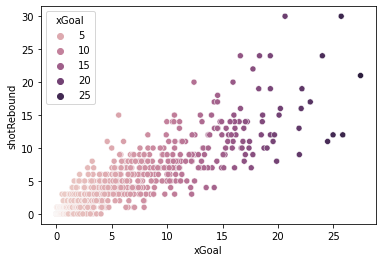

In [636]:
sns.scatterplot(
    data=shooter_xgb, x="xGoal", y="shotRebound", hue="xGoal",
    sizes=(20, 250)
)

In [637]:
# Create game-level dataset for shooters

shooter_game = xgboost_xg[['teamCode','shooterName', 'game_id', 'xGoal', 'goal', 'GSAx']]
shooter_game=shooter_game.groupby(['teamCode','game_id','shooterName']).sum()
shooter_game.drop(columns=['GSAx'], inplace=True)
shooter_game['GoalsAboveExpected']=shooter_game['goal']-shooter_game['xGoal']
shooter_game=shooter_game.reset_index()
shooter_game=shooter_game.astype({'game_id':'int64','goal':'int64'})
display(shooter_game.groupby(['game_id','teamCode','shooterName']).sum())

xGoal  goal  GoalsAboveExpected
game_id teamCode shooterName                                          
20001   NSH      Alexandre Carrier  0.179240     0           -0.179240
                 Cody Glass         0.142380     0           -0.142380
                 Colton Sissons     0.055951     0           -0.055951
                 Dante Fabbro       0.037631     0           -0.037631
                 Eeli Tolvanen      0.263126     1            0.736874
...                                      ...   ...                 ...
20621   LAK      Phillip Danault    0.254030     1            0.745970
                 Quinton Byfield    0.697462     0           -0.697462
                 Sean Durzi         0.097734     1            0.902266
                 Sean Walker        0.006522     0           -0.006522
                 Viktor Arvidsson   0.288281     0           -0.288281

[18886 rows x 3 columns]

In [111]:
# Save dataset

shooter_game.to_csv(r'/Users/kyledelaney/Downloads/shooter_game2022.csv', index=False)

In [638]:
# Create game-level shooter v. goalie dataset

shooter_shot = xgboost_xg[['teamCode','shooterName','goalieNameForShot', 'game_id', 'xGoal', 'goal', 'GSAx','shotType', 'shotWasOnGoal']]
shooter_shot=shooter_shot.groupby(['teamCode','game_id','shooterName','goalieNameForShot','shotType']).sum()
shooter_shot=shooter_shot.reset_index()
shooter_shot=shooter_shot.astype({'game_id':'int64','goal':'int64', 'shotWasOnGoal':'int64'})
display(shooter_shot.groupby(['game_id','shooterName','goalieNameForShot','shotType']).sum())

xGoal  goal  \
game_id shooterName       goalieNameForShot shotType                   
20001   Alexandre Carrier James Reimer      BACK      0.179240     0   
        Cody Glass        James Reimer      WRIST     0.142380     0   
        Colton Sissons    James Reimer      WRIST     0.055951     0   
        Dante Fabbro      James Reimer      SNAP      0.030184     0   
                                            WRIST     0.007447     0   
...                                                        ...   ...   
20621   Trent Frederic    Pheonix Copley    WRIST     0.093002     0   
        Viktor Arvidsson  Jeremy Swayman    SLAP      0.061174     0   
                                            SNAP      0.110588     0   
                                            TIP       0.095890     0   
                                            WRIST     0.020629     0   

                                                          GSAx  shotWasOnGoal  
game_id shooterName       goalieNameForShot shotType                           
20001   Alexandre Carrier James Reimer      BACK      0.179240              0  
        Cody Glass        James Reimer      WRIST     0.142380              1  
        Colton Sissons    James Reimer      WRIST     0.055951              1  
        Dante Fabbro      James Reimer      SNAP      0.030184              1  
                                            WRIST     0.007447              1  
...                                                        ...            ...  
20621   Trent Frederic    Pheonix Copley    WRIST     0.093002              1  
        Viktor Arvidsson  Jeremy Swayman    SLAP      0.061174              1  
                                            SNAP      0.110588              2  
                                            TIP       0.095890              1  
                                            WRIST     0.020629              1  

[35065 rows x 4 columns]

In [113]:
# Save dataset

shooter_shot.to_csv(r'/Users/kyledelaney/Downloads/shootervsgoalie2022.csv', index=False)

In [639]:
# Create season-level GameScore dataset for goalies

season_score=game_score_xgb[['goalieNameForShot','goalieTeam', 'season','xGoal', 'goal', 'GSAx', 'xRebound', 'RSAx', 'gameScore','GP', 'shotSaved', 'shotWasOnGoal', 'shotGoalieFroze','shotRush', 'shotRebound']]
season_score=season_score.groupby(['goalieNameForShot','goalieTeam','season']).sum()
season_score['gameScoreAVG']=season_score['gameScore']/season_score['GP']
season_score.drop(columns=['gameScore'], inplace=True)
season_score['savePCT']=season_score['shotSaved']/season_score['shotWasOnGoal']
season_score['xSvPCT'] = (season_score['shotWasOnGoal']-season_score['xGoal']) / season_score['shotWasOnGoal']
season_score['SPAx'] = season_score['savePCT'] - season_score['xSvPCT']
season_score=season_score.astype({'shotSaved':'int64','shotWasOnGoal':'int64'})
season_score=season_score.sort_values(by=['GSAx'], ascending=False)
season_score=season_score.reset_index()
display(season_score.style.format({'savePCT': "{:.2%}",'xSvPCT': "{:.2%}", 'SPAx':"{:.2%}"}))

,goalieNameForShot,goalieTeam,season,xGoal,goal,GSAx,xRebound,RSAx,GP,shotSaved,shotWasOnGoal,shotGoalieFroze,shotRush,shotRebound,gameScoreAVG,savePCT,xSvPCT,SPAx
0,Juuse Saros,NSH,2022,118.961952,79,39.961950,71.709806,-29.290194,29,880,959,213,4,101,1.354278,91.76%,87.60%,4.17%
1,Ilya Sorokin,NYI,2022,103.888550,66,37.888553,63.671437,-43.328563,30,807,873,181,2,107,1.346671,92.44%,88.10%,4.34%
2,Linus Ullmark,BOS,2022,75.877609,45,30.877605,50.978757,-21.021243,25,687,732,172,1,72,1.726489,93.85%,89.63%,4.22%
3,Connor Hellebuyck,WPG,2022,93.962723,66,27.962725,64.778901,-18.221099,29,869,935,161,1,83,1.547509,92.94%,89.95%,2.99%
4,Andrei Vasilevskiy,TBL,2022,89.024643,63,26.024647,56.529043,-7.470957,26,736,799,152,2,64,1.299379,92.12%,88.86%,3.26%
5,Carter Hart,PHI,2022,102.733627,77,25.733631,64.629526,-26.370474,28,786,863,197,4,91,0.973270,91.08%,88.10%,2.98%
6,Jake Oettinger,DAL,2022,88.845428,66,22.845426,59.261921,-7.738079,29,764,830,168,4,67,1.150577,92.05%,89.30%,2.75%
7,Karel Vejmelka,ARI,2022,113.170502,93,20.170499,72.796562,-16.203438,28,864,957,238,0,89,0.781821,90.28%,88.17%,2.11%
8,Stuart Skinner,EDM,2022,84.460762,66,18.460765,53.972533,-16.027467,24,714,780,176,2,70,1.109869,91.54%,89.17%,2.37%
9,Igor Shesterkin,NYR,2022,87.194778,71,16.194781,59.214347,-0.785653,29,782,853,135,2,60,1.026522,91.68%,89.78%,1.90%


In [642]:
team_xg = season_score[['goalieTeam', 'xGoal', 'goal', 'GSAx', 'season', 'shotWasOnGoal', 'shotSaved', 'shotGoalieFroze','shotRush', 'shotRebound']]
team_xg = team_xg.rename(columns={'goalieTeam':'teamCode', 'goal':'GA', 'xGoal':'xGA', 'shotWasOnGoal':'sogAgainst', 'shotRush':'shotRushAgainst', 'shotRebound':'shotReboundAgainst'})
team_xg = team_xg.groupby(['teamCode', 'season']).sum()
team_xg1 = shooter_xgb[['teamCode', 'xGoal', 'goal', 'GoalsAboveExpected', 'season', 'shot_attempt','shotWasOnGoal', 'shotGeneratedRebound','shotRush', 'shotRebound']]
team_xg1 = team_xg1.groupby(['teamCode', 'season']).sum()
team_xg = team_xg.join(team_xg1, how='right')
team_xg['xGPCT'] = team_xg['xGoal']/(team_xg['xGoal']+team_xg['xGA'])
team_xg['aGPCT'] = team_xg['goal']/(team_xg['goal']+team_xg['GA'])
team_xg['gPCTdiff'] = team_xg['aGPCT'] - team_xg['xGPCT']
team_xg['shootingPCT'] = team_xg['goal'] / team_xg['shot_attempt']
team_xg['xShootingPCT'] = team_xg['xGoal'] / team_xg['shot_attempt']
team_xg['savePCT']=team_xg['shotSaved']/team_xg['sogAgainst']
team_xg['xSvPCT'] = (team_xg['sogAgainst']-team_xg['xGoal']) / team_xg['sogAgainst']
team_xg=team_xg.sort_values(by=['xGPCT'], ascending=False)
team_xg=team_xg.astype({'shotSaved':'int64','sogAgainst':'int64'})
team_xg=team_xg.reset_index()
display(team_xg.style.format({'savePCT': "{:.2%}",'xSvPCT': "{:.2%}", 'xGPCT':"{:.2%}", 'aGPCT':"{:.2%}", 'gPCTdiff':"{:.2%}", 'shootingPCT':"{:.2%}", 'xShootingPCT':"{:.2%}"}))

,teamCode,season,xGA,GA,GSAx,sogAgainst,shotSaved,shotGoalieFroze,shotRushAgainst,shotReboundAgainst,xGoal,goal,GoalsAboveExpected,shot_attempt,shotWasOnGoal,shotGeneratedRebound,shotRush,shotRebound,xGPCT,aGPCT,gPCTdiff,shootingPCT,xShootingPCT,savePCT,xSvPCT
0,CAR,2022,109.606430,97,12.606433,1020,923,194,4,91,154.853149,120,-34.853153,2008,1391,179,3,180,58.55%,55.30%,-3.26%,5.98%,7.71%,90.49%,84.82%
1,NJD,2022,115.848480,96,19.848482,1052,956,190,2,105,158.647034,132,-26.647032,1883,1352,124,4,124,57.80%,57.89%,0.10%,7.01%,8.43%,90.87%,84.92%
2,TOR,2022,118.411423,98,20.411429,1103,1005,249,3,112,153.070557,131,-22.070554,1711,1232,116,6,116,56.38%,57.21%,0.82%,7.66%,8.95%,91.12%,86.12%
3,BOS,2022,122.232475,81,41.232471,1113,1032,265,3,103,157.284119,142,-15.284121,1733,1307,115,4,115,56.27%,63.68%,7.41%,8.19%,9.08%,92.72%,85.87%
4,VGK,2022,119.080750,109,10.080752,1236,1127,291,3,99,152.594009,135,-17.594011,1808,1341,112,0,112,56.17%,55.33%,-0.84%,7.47%,8.44%,91.18%,87.65%
5,FLA,2022,131.238937,122,9.238941,1229,1107,263,6,116,165.054611,128,-37.054613,1925,1414,143,11,143,55.71%,51.20%,-4.51%,6.65%,8.57%,90.07%,86.57%
6,NYR,2022,120.435455,102,18.435455,1152,1050,202,3,84,144.754547,130,-14.754541,1831,1302,93,5,93,54.59%,56.03%,1.45%,7.10%,7.91%,91.15%,87.43%
7,CGY,2022,120.319206,110,10.319206,1083,973,263,1,87,144.169861,118,-26.169866,1879,1359,121,8,121,54.51%,51.75%,-2.75%,6.28%,7.67%,89.84%,86.69%
8,TBL,2022,129.838943,98,31.838952,1140,1042,255,2,103,154.828766,130,-24.828769,1652,1182,125,2,125,54.39%,57.02%,2.63%,7.87%,9.37%,91.40%,86.42%
9,PIT,2022,127.323059,110,17.323063,1275,1165,248,6,101,150.925385,123,-27.925379,1698,1226,130,7,130,54.24%,52.79%,-1.45%,7.24%,8.89%,91.37%,88.16%


In [618]:
team_xg.to_csv(r'/Users/kyledelaney/Downloads/team_xgb2022.csv', index=False)

In [619]:
season_score.to_csv(r'/Users/kyledelaney/Downloads/season_scorexgb2022.csv', index=False)

<AxesSubplot:xlabel='GP', ylabel='xGoal'>

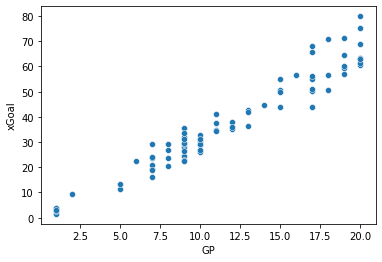

In [389]:
sns.scatterplot(
    data=season_score, x="GP", y="xGoal",
    sizes=(20, 250),
)

In [54]:
pip install hockey_rink

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [55]:
from hockey_rink import NHLRink

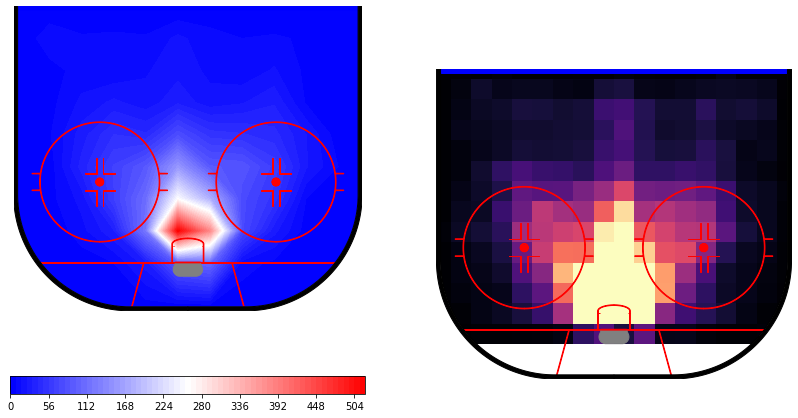

In [575]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
rink = NHLRink(rotation=270)
for i in range(2):
    rink.draw(ax=axs[i], display_range="ozone")
contour_img = rink.contourf(xgboost_xg.arenaAdjustedXCordABS, xgboost_xg.arenaAdjustedYCord, values=xgboost_xg.goal, ax=axs[0], cmap="bwr", 
                            plot_range="ozone", binsize=8, levels=75, statistic="sum")
plt.colorbar(contour_img, ax=axs[0], orientation="horizontal")
rink.heatmap(xgboost_xg.arenaAdjustedXCordABS, xgboost_xg.arenaAdjustedYCord, values=xgboost_xg.xGoal, ax=axs[1], cmap="magma",
             plot_xlim=(25, 89), statistic="sum", vmax=50, binsize=5)